# Fashion-MNIST Image Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) for classifying Fashion-MNIST images into 10 categories:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot



In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)



TensorFlow version: 2.20.0
Keras version: 3.12.0


## 1. Load and Preprocess Data



In [2]:
def load_data(data_dir):
    """
    Load images from directory structure where each class has its own folder
    """
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
        
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_array = np.array(img)
            images.append(img_array)
            labels.append(class_idx)
    
    return np.array(images), np.array(labels), class_names

# Load training and test data
print("Loading training data...")
X_train, y_train, class_names = load_data('train')
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

print("\nLoading test data...")
X_test, y_test, _ = load_data('test')
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

print(f"\nClass names: {class_names}")
print(f"Number of classes: {len(class_names)}")



Loading training data...
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)

Loading test data...
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of classes: 10


In [3]:
# Data preprocessing
# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to include channel dimension (28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# One-hot encode labels
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

print("Preprocessed training data shape:", X_train.shape)
print("Preprocessed test data shape:", X_test.shape)
print("Training labels (categorical) shape:", y_train_categorical.shape)
print("Test labels (categorical) shape:", y_test_categorical.shape)



Preprocessed training data shape: (60000, 28, 28, 1)
Preprocessed test data shape: (10000, 28, 28, 1)
Training labels (categorical) shape: (60000, 10)
Test labels (categorical) shape: (10000, 10)


## 2. Visualize Sample Images



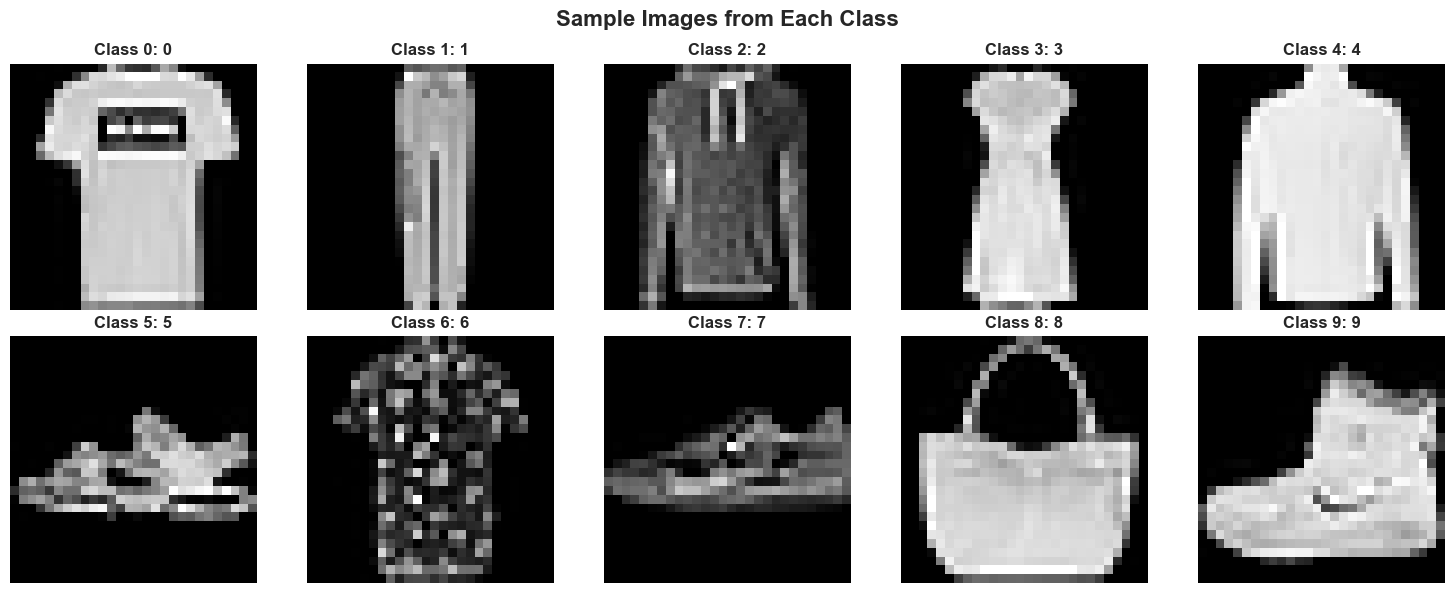

In [4]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for i in range(10):
    row = i // 5
    col = i % 5
    # Find first image of each class
    class_idx = np.where(y_train == i)[0][0]
    axes[row, col].imshow(X_train[class_idx].squeeze(), cmap='gray')
    axes[row, col].set_title(f'Class {i}: {class_names[i]}', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()



## 3. Build CNN Model



In [5]:
def create_cnn_model():
    """
    Create a CNN model for Fashion-MNIST classification
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.25),
        
        # Flatten and Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    return model

# Create the model
model = create_cnn_model()

# Display model architecture
model.summary()



c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,488,490 (13.31 MB)

 Trainable params: 3,486,506 (13.30 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [6]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")



Model compiled successfully!


## 4. Train the Model



In [ ]:
# Define callbacks (EarlyStopping kept, but delayed so it won't stop too early)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    start_from_epoch=40,  # do not consider stopping before epoch 40
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# Train the model
batch_size = 128
epochs = 50

print("Starting training...")
history = model.fit(
    X_train, y_train_categorical,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")



Starting training...
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 174ms/step - accuracy: 0.7701 - loss: 0.6525 - val_accuracy: 0.0000e+00 - val_loss: 6.3971 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 188ms/step - accuracy: 0.8607 - loss: 0.3787 - val_accuracy: 0.0000e+00 - val_loss: 8.3176 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 179ms/step - accuracy: 0.8794 - loss: 0.3253 - val_accuracy: 0.0000e+00 - val_loss: 8.3583 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 140ms/step - accuracy: 0.8901 - loss: 0.2973 - val_accuracy: 0.0000e+00 - val_loss: 8.3970 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - accuracy: 0.9002 - loss: 0.2726 - val_accuracy: 0.0000e+00 - val_loss: 8.2313 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8994 - loss: 0.2704
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
375/375 ━━━━━━━━━━━━

## 5. Visualize Training History



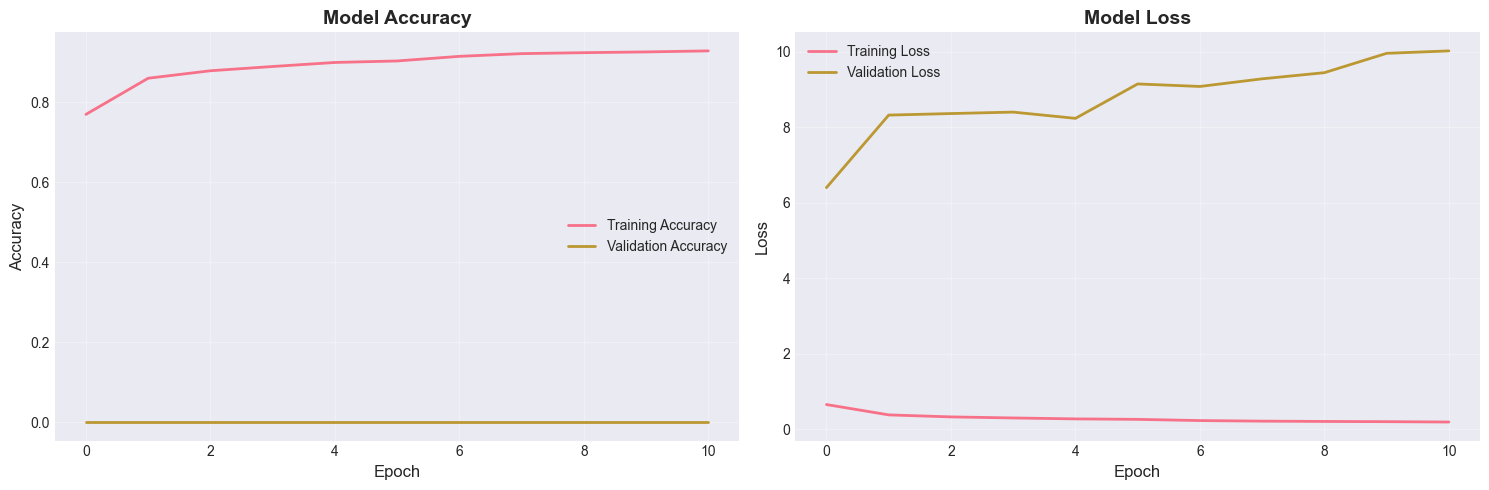

In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 6. Evaluate on Test Data



In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)

print("=" * 50)
print("TEST RESULTS")
print("=" * 50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("=" * 50)



TEST RESULTS
Test Loss: 2.3428
Test Accuracy: 0.4613 (46.13%)


In [10]:
# Make predictions on test data
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
print("\nClassification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=class_names))
print("=" * 50)




Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.96      0.59      1000
           1       1.00      0.92      0.96      1000
           2       0.40      0.90      0.56      1000
           3       0.87      0.65      0.75      1000
           4       0.75      0.01      0.02      1000
           5       1.00      0.14      0.25      1000
           6       0.50      0.01      0.03      1000
           7       0.28      1.00      0.43      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.46     10000
   macro avg       0.52      0.46      0.36     10000
weighted avg       0.52      0.46      0.36     10000



c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## 7. Confusion Matrix



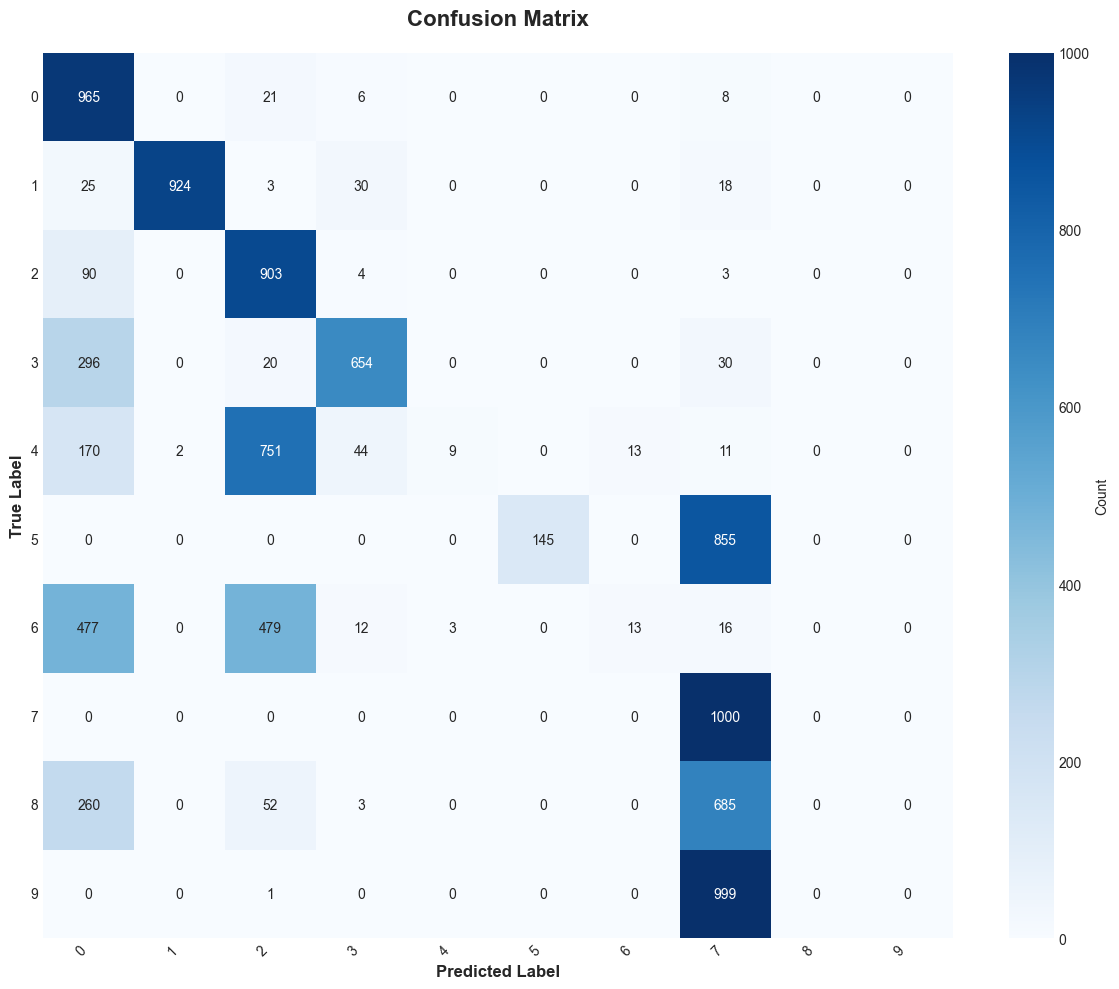

In [11]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## 8. Visualize Sample Predictions



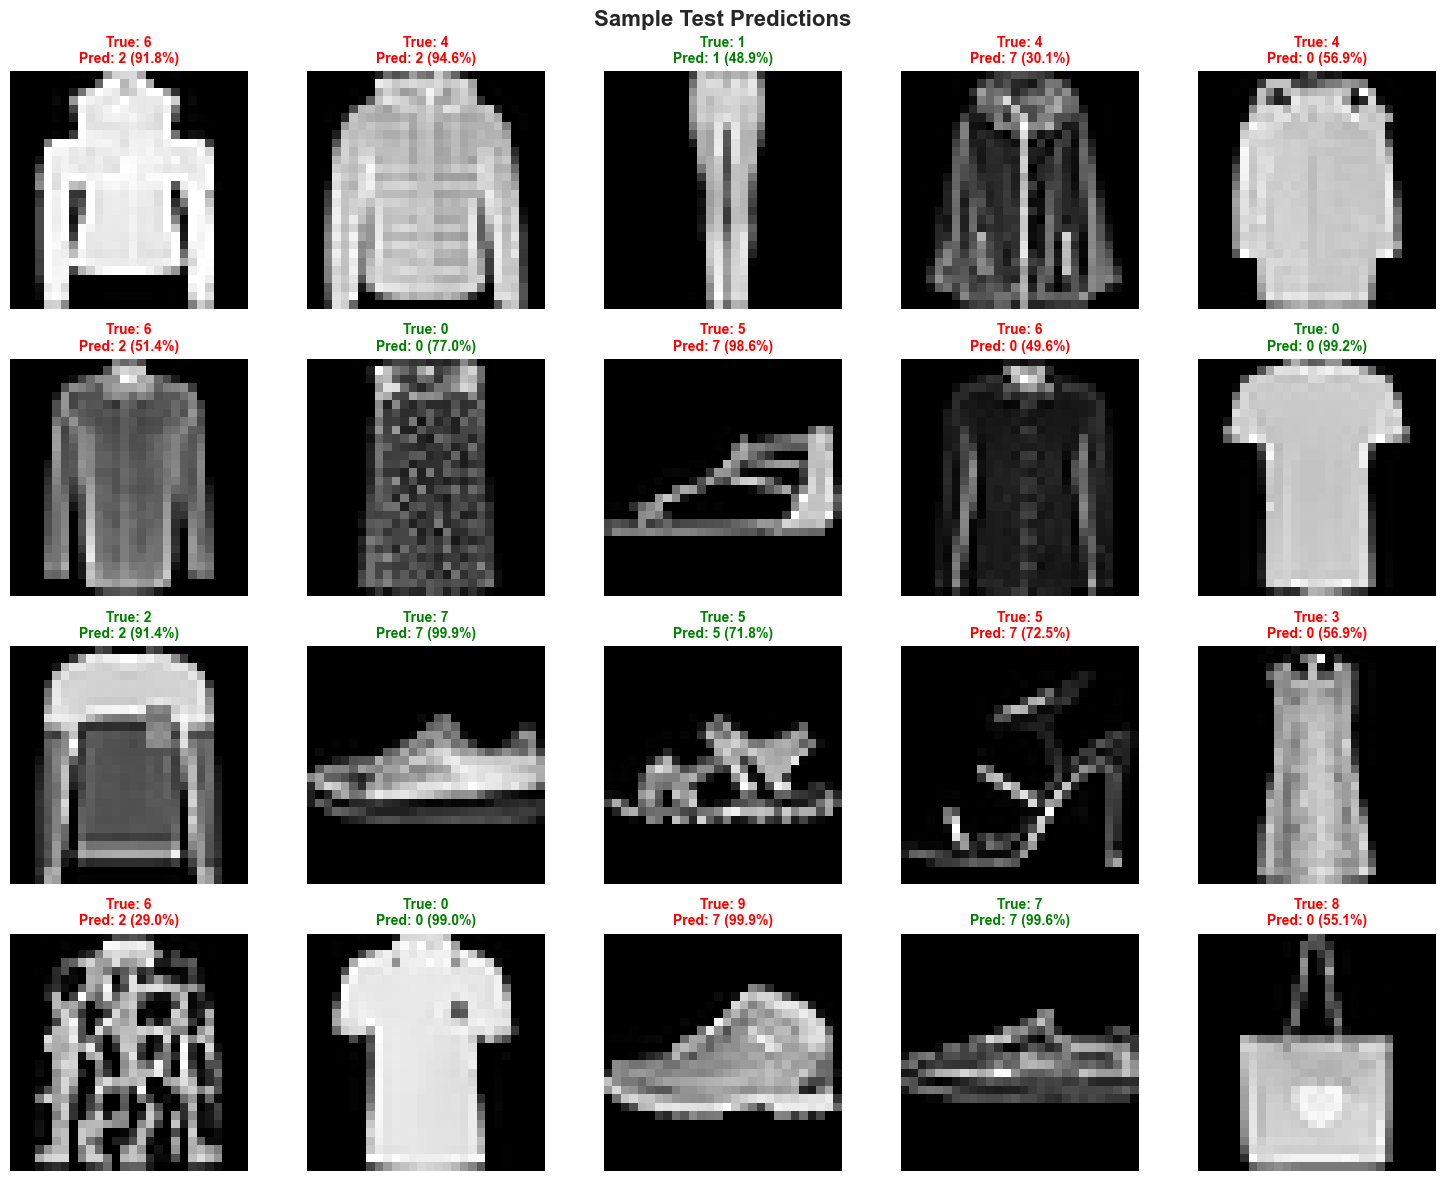

In [12]:
# Visualize some test predictions
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Sample Test Predictions', fontsize=16, fontweight='bold')

# Select random samples
indices = np.random.choice(len(X_test), 20, replace=False)

for idx, ax in enumerate(axes.flat):
    i = indices[idx]
    ax.imshow(X_test[i].squeeze(), cmap='gray')
    
    true_label = y_test[i]
    pred_label = y_pred[i]
    confidence = y_pred_proba[i][pred_label] * 100
    
    # Color: green if correct, red if wrong
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.1f}%)'
    ax.set_title(title, color=color, fontweight='bold', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()



## 9. Save the Model



In [ ]:
# Save the trained model (Keras 3 compatible)
# 1) Native Keras format (.keras)
try:
    model.save('fashion_mnist_cnn_model.keras')
    print("Model saved as 'fashion_mnist_cnn_model.keras'")
except Exception as e:
    print(f"Error saving .keras model: {e}")

# 2) TensorFlow SavedModel directory
try:
    model.export('fashion_mnist_cnn_savedmodel')  # Keras 3 API
    print("Model exported to SavedModel directory 'fashion_mnist_cnn_savedmodel'")
except Exception as e:
    print(f"Error exporting SavedModel: {e}")



Model saved as 'fashion_mnist_cnn_model.h5'


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=fashion_mnist_cnn_model_savedmodel.

## 10. Per-Class Accuracy Analysis



In [ ]:
# Calculate per-class accuracy
class_accuracies = []
for i in range(10):
    class_mask = y_test == i
    class_correct = np.sum((y_test == i) & (y_pred == i))
    class_total = np.sum(class_mask)
    class_acc = class_correct / class_total if class_total > 0 else 0
    class_accuracies.append(class_acc)

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(range(10), [acc * 100 for acc in class_accuracies], color='steelblue', edgecolor='black', linewidth=1.5)
plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Class Test Accuracy', fontsize=14, fontweight='bold', pad=15)
plt.xticks(range(10), class_names, rotation=45, ha='right')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, class_accuracies)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc*100:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\nPer-Class Accuracy:")
print("-" * 50)
for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
    print(f"{i}: {class_name:15s} - {acc*100:6.2f}%")
print("-" * 50)

